# **Farouk Benkhelifa**

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU ,BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping

import re

In [2]:
# Load datasets
dataset_training = pd.read_csv("twitter_training.csv")
dataset_validation = pd.read_csv("twitter_validation.csv")
dataset_training.columns = ['Tweet ID', 'entity', 'sentiment', 'Tweet content']
dataset_validation.columns = ['Tweet ID', 'entity', 'sentiment', 'Tweet content']

In [3]:
a=np.random.randn(1,3)

b=np.random.randn(3,3) 
c=a*b
print(c.shape)

(3, 3)


In [4]:
# Drop missing values
dataset_training.dropna(subset=['Tweet content'], inplace=True)
dataset_validation.dropna(subset=['Tweet content'], inplace=True)

In [5]:
# Split into features and target
y_train = dataset_training['sentiment']
X_train = dataset_training.drop('sentiment', axis=1)
y_test = dataset_validation['sentiment']
X_test = dataset_validation.drop('sentiment', axis=1)

In [6]:
# Encode 'entity' column using OrdinalEncoder
ordi = OrdinalEncoder()
X_train['entity'] = ordi.fit_transform(X_train[['entity']])
X_test['entity'] = ordi.transform(X_test[['entity']])

In [7]:
# One-Hot encode 'sentiment' target
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_train_encoded = encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.to_numpy().reshape(-1, 1))

In [8]:
# Train-test split (validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42
)

In [9]:
# Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text
# Apply cleaning function to 'Tweet content'
X_train['cleaned_text'] = X_train['Tweet content'].apply(clean_text)
X_valid['cleaned_text'] = X_valid['Tweet content'].apply(clean_text)
X_test['cleaned_text'] = X_test['Tweet content'].apply(clean_text)

In [10]:
# Drop original 'Tweet content' column
X_train = X_train.drop(['Tweet content'], axis=1)
X_valid = X_valid.drop(['Tweet content'], axis=1)
X_test = X_test.drop(['Tweet content'], axis=1)

In [11]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=6000)
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_text']).toarray()
X_valid_tfidf = vectorizer.transform(X_valid['cleaned_text']).toarray()
X_test_tfidf = vectorizer.transform(X_test['cleaned_text']).toarray()

In [12]:
# Drop 'cleaned_text' column after TF-IDF transformation
X_train = X_train.drop(['cleaned_text'], axis=1)
X_valid = X_valid.drop(['cleaned_text'], axis=1)
X_test = X_test.drop(['cleaned_text'], axis=1)

In [13]:
# Convert the numerical features into numpy arrays
X_train_numerical = X_train.to_numpy()
X_valid_numerical = X_valid.to_numpy()
X_test_numerical = X_test.to_numpy()

In [14]:
# Combine the numerical features with the TF-IDF features
X_train_combined = np.hstack([X_train_tfidf, X_train_numerical])
X_valid_combined = np.hstack([X_valid_tfidf, X_valid_numerical])
X_test_combined = np.hstack([X_test_tfidf, X_test_numerical])

In [15]:
X_train_combined.shape[1]

6002

In [18]:
model = Sequential([
    Dense(512, input_dim=X_train_combined.shape[1]),
    Activation('elu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(256),
    Activation('elu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128),
    Activation('elu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64),
    Activation('elu'),    
    
    Dense(4, activation='softmax')  # 4 sentiment classes
])

In [19]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model and store history
history = model.fit(
    X_train_combined, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_valid_combined, y_valid), 
    callbacks=[early_stopping]
)

Epoch 1/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 104s 54ms/step - accuracy: 0.2769 - loss: 1.7603 - val_accuracy: 0.3285 - val_loss: 1.3763
Epoch 2/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 101s 55ms/step - accuracy: 0.3009 - loss: 1.4533 - val_accuracy: 0.3285 - val_loss: 1.3657
Epoch 3/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 97s 52ms/step - accuracy: 0.3073 - loss: 1.4057 - val_accuracy: 0.3290 - val_loss: 1.3585
Epoch 4/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 99s 53ms/step - accuracy: 0.3143 - loss: 1.3836 - val_accuracy: 0.3352 - val_loss: 1.3538
Epoch 5/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 97s 52ms/step - accuracy: 0.3212 - loss: 1.3712 - val_accuracy: 0.3323 - val_loss: 1.3544
Epoch 6/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 99s 53ms/step - accuracy: 0.3238 - loss: 1.3666 - val_accuracy: 0.3202 - val_loss: 1.3514
Epoch 7/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 103s 56ms/step - accuracy: 0.3256 - loss: 1.3651 - val_accuracy: 0.3356 - val_loss: 1.3532
Epoch 8/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 103s 56ms/step - accuracy: 0.32

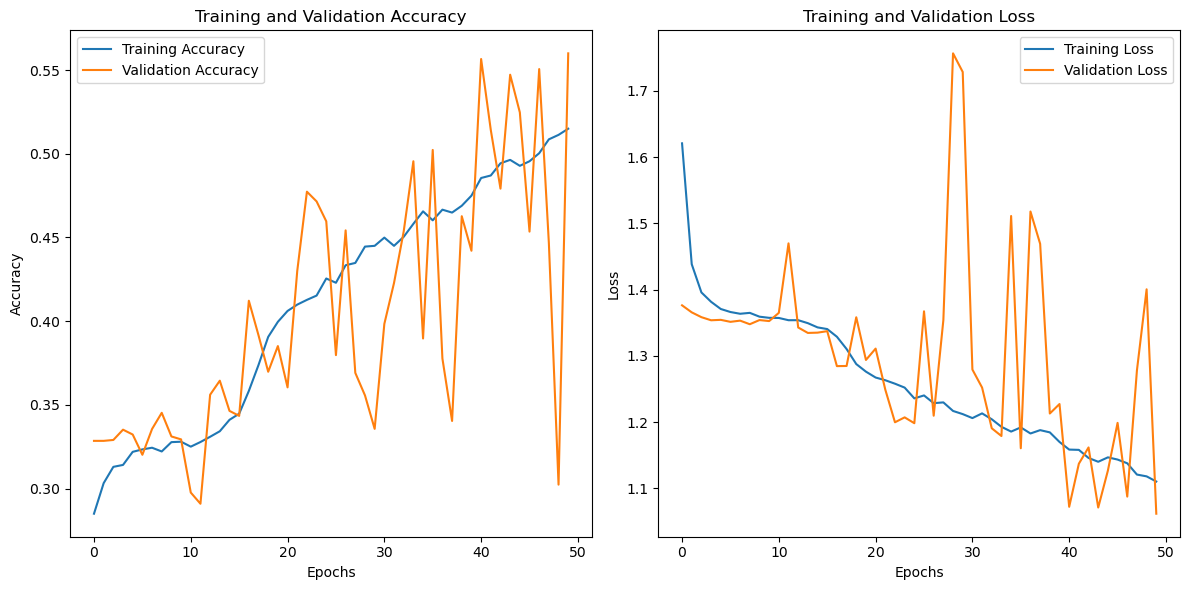

In [20]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [21]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6045 - loss: 0.9927
Test Accuracy: 60.66%
